In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jacquelineburos/anaconda3/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
model_code = survivalstan.models.pem_survival_model_randomwalk

In [3]:
print(model_code)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>


data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int

In [4]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,age,sex,rate,true_t,t,event,index,age_centered
0,66,male,0.082085,10.147691,10.147691,True,0,10.68
1,56,female,0.049787,0.367137,0.367137,True,1,0.68
2,64,male,0.082085,9.405635,9.405635,True,2,8.68
3,50,female,0.049787,37.622991,20.000000,False,3,-5.32
4,51,female,0.049787,18.443852,18.443852,True,4,-4.32


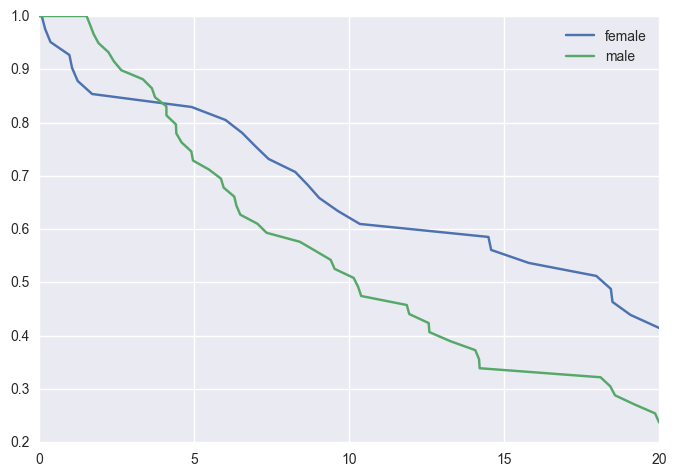

In [5]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [6]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')
dlong.sort_values(['index','end_time'], inplace=True)

In [7]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
17,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.085974,False
59,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.195506,False
1,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.367137,False
68,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,0.978347,False
58,66,male,0.082085,10.147691,10.147691,True,0,10.68,1,1.064155,False


In [8]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = model_code,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_15125303112.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_249db4a4181526e159f2a1b68f29066d NOW.
INFO:stancache.stancache:StanModel: Execution completed (0:00:40.353976 elapsed)
INFO:stancache.stancache:StanModel: Saving results to cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_15125303112.pystan_2_12_0_0.stanfit.chains_4.data_37590316055.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:20:23.611008 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/Users/jacquelineburos/anaconda3/envs/p

In [9]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean       sd        2.5%         50%       97.5%      Rhat
lp__ -281.738185  1.657586  23.2062 -324.950216 -282.246106 -234.850331  1.011358


In [10]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

                          mean   se_mean        sd      2.5%       50%     97.5%      Rhat
log_baseline_raw[0]  -2.155087  0.036315  0.783925 -3.698047 -2.169002 -0.619414  1.013726
log_baseline_raw[1]  -2.266143  0.036644  0.772141 -3.773999 -2.265415 -0.749086  1.014916
log_baseline_raw[2]  -2.407101  0.037161  0.766087 -3.893493 -2.403207 -0.886243  1.015412
log_baseline_raw[3]  -2.555007  0.037997  0.769374 -4.051081 -2.554637 -1.018501  1.015454
log_baseline_raw[4]  -2.691823  0.038798  0.774990 -4.206748 -2.686754 -1.144308  1.015795
log_baseline_raw[5]  -2.814785  0.039694  0.780881 -4.314956 -2.807261 -1.252556  1.015750
log_baseline_raw[6]  -2.929257  0.040876  0.788381 -4.442055 -2.932126 -1.364671  1.015604
log_baseline_raw[7]  -3.029380  0.041464  0.796494 -4.567946 -3.025959 -1.463720  1.015062
log_baseline_raw[8]  -3.122872  0.042537  0.808209 -4.700155 -3.120778 -1.521283  1.014682
log_baseline_raw[9]  -3.207944  0.043751  0.820832 -4.794595 -3.206714 -1.558586  1.014550

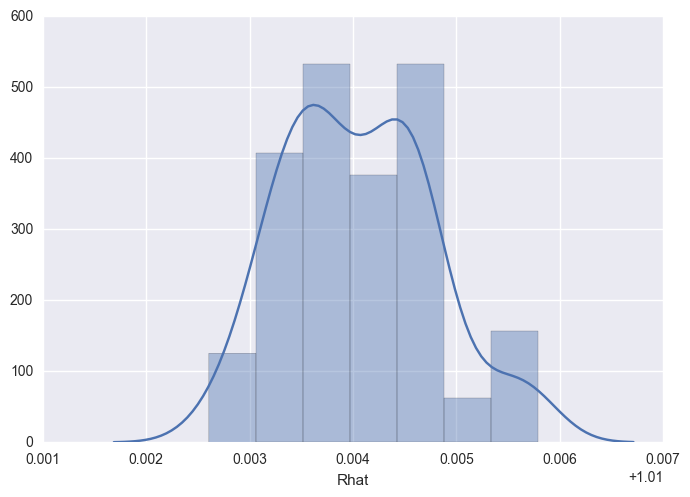

In [11]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

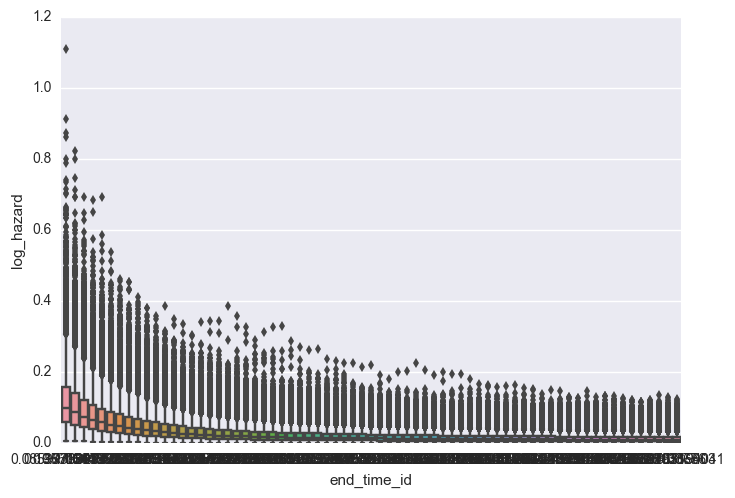

In [12]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

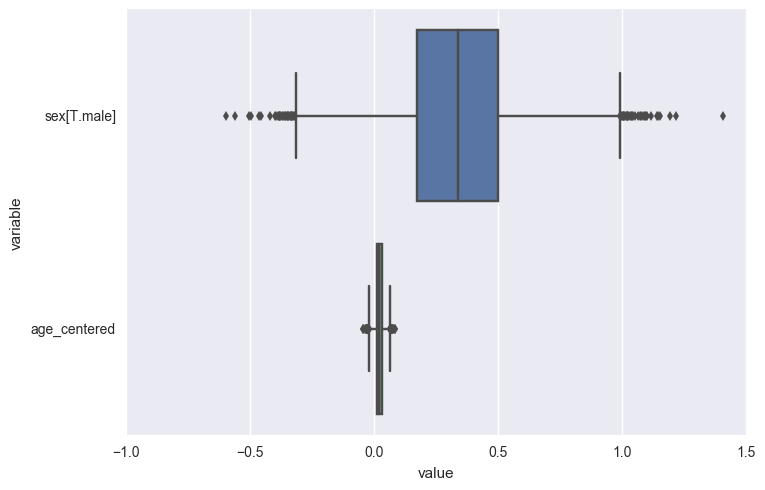

In [13]:
survivalstan.utils.plot_coefs([testfit])

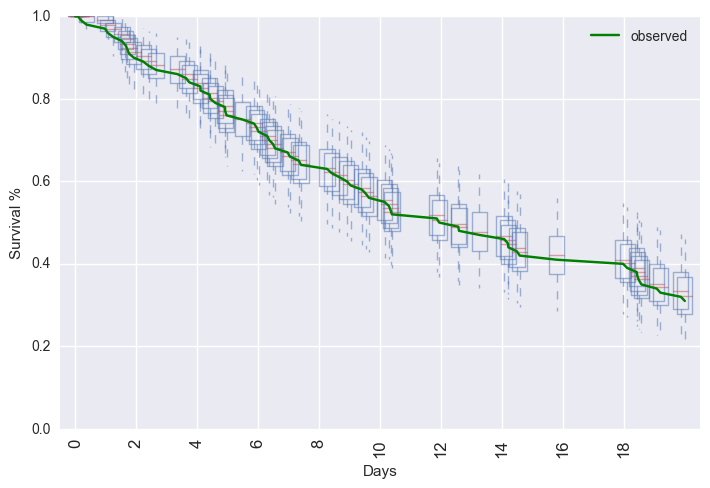

In [14]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

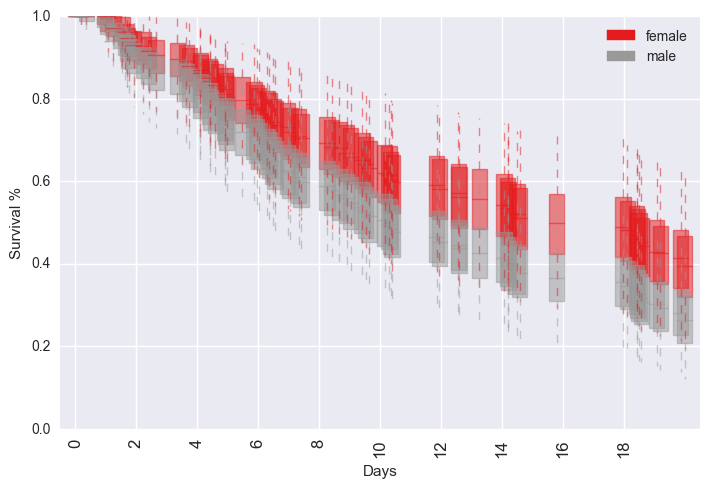

In [15]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')